In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from pathlib import Path
from tqdm.auto import tqdm
import csv

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

from TokEye.extra.eval.silbidopy.data import AudioTonalDataset
from TokEye.extra.eval.silbidopy.eval import Metrics

In [3]:
blue_cmap = ListedColormap(['none', 'blue'])
red_cmap = ListedColormap(['none', 'red'])

In [4]:
metrics = Metrics(device="cpu")

In [5]:
root_path = Path("/scratch/gpfs/nc1514/TokEye")
eval_base_path = root_path / "data" / "eval" / "DCLDE2011"
model_path = root_path / "model" / "big_mode_v1-5.pt"
output_path = root_path / "data" / "eval" / "results" / "DCLDE2011.csv"

In [6]:
model = torch.load(
    model_path, 
    weights_only=False, 
    map_location=device
)
model.eval()
print("Model loaded")

Model loaded


In [7]:
species_name = "Delphinus capensis"
data_dir = eval_base_path / species_name

In [8]:
dataset = AudioTonalDataset(
    data_dir, data_dir, 
    annotation_extension = "ann",
    time_patch_frames=250, freq_patch_frames=250,
    )

mean, std = 0, 0
for i in tqdm(range(len(dataset))):
    spec, _ = dataset[i]
    mean += spec.mean()
    std += spec.std()

mean /= len(dataset)
std /= len(dataset)

print(f"Mean: {mean}, Std: {std}")

['/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0808-TA26-080826-163000.ann', '/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0810-TA30-081029-232000.ann', '/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0707-TA33-070713-202000.ann']


  0%|          | 0/778 [00:00<?, ?it/s]

Mean: 0.7080333218912784, Std: 0.051389602618240104


In [9]:
class Processor:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        x = (x - self.mean) / self.std
        return x

In [10]:
post_processing_function = Processor(
    mean=mean,
    std=std,
)

dataset = AudioTonalDataset(
    data_dir, data_dir, 
    annotation_extension = "ann",
    time_patch_frames=250, freq_patch_frames=250,
    post_processing_function=post_processing_function,
    )

['/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0808-TA26-080826-163000.ann', '/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0810-TA30-081029-232000.ann', '/scratch/gpfs/nc1514/TokEye/data/eval/DCLDE2011/Delphinus capensis/CC0707-TA33-070713-202000.ann']


In [11]:
data = dataset[5]

In [12]:
remove_bins = 2
threshold = 0.5

In [101]:
spec, ann = dataset[270]

ann_tensor = torch.from_numpy(ann)
ann_tensor = ann_tensor.unsqueeze(0).unsqueeze(0).float()

spec_tensor = torch.from_numpy(spec)
spec_tensor = spec_tensor.unsqueeze(0).unsqueeze(0).float()

with torch.no_grad():
    spec_tensor = spec_tensor.to(device)
    out_tensor = model(spec_tensor)[0]

out_tensor = out_tensor[:,0:1]
out_tensor = torch.sigmoid(out_tensor)
out_tensor = out_tensor.cpu()

scores = metrics(out_tensor > threshold, ann_tensor)
out = out_tensor.squeeze(0).squeeze(0).numpy()

In [102]:
for key, value in scores.items():
    print(f"{key}: {value}")

generalized_dice_score: 0.04262382164597511
hausdorff_distance: 186.45375061035156
iou: 0.021776000037789345
precision: 0.16311535239219666
recall: 0.925000011920929


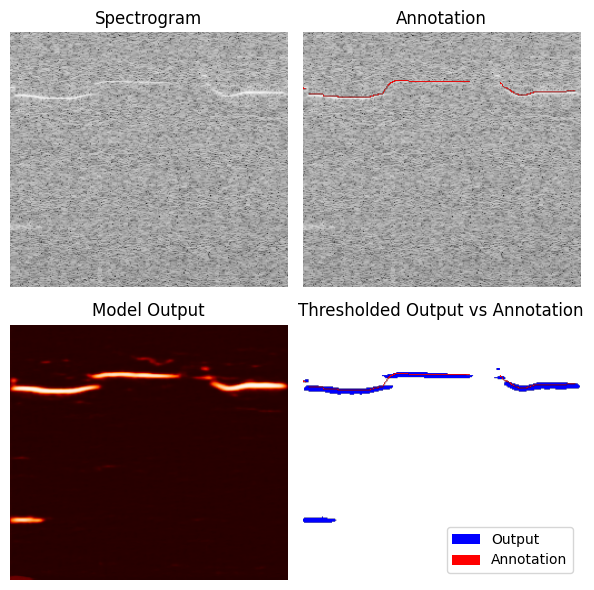

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(spec, aspect="auto", cmap="gray", origin="lower")
axes[0, 0].set_title("Spectrogram")
axes[0, 0].axis("off")

axes[0, 1].imshow(spec, aspect="auto", cmap="gray", origin="lower")
axes[0, 1].imshow(ann, aspect="auto", cmap=red_cmap, alpha=ann.astype(float), origin="lower")
axes[0, 1].set_title("Annotation")
axes[0, 1].axis("off")

axes[1, 0].imshow(out, aspect="auto", cmap="gist_heat", vmin=0, vmax=1, origin="lower")
axes[1, 0].set_title("Model Output")
axes[1, 0].axis("off")

axes[1, 1].imshow(out > threshold, aspect="auto", cmap=blue_cmap, label="Model", origin="lower")
axes[1, 1].imshow(ann, aspect="auto", cmap=red_cmap, label="Annotation", zorder=2, origin="lower")
axes[1, 1].set_title("Thresholded Output vs Annotation")
legend_elements = [
    Patch(facecolor='blue', label='Output'),
    Patch(facecolor='red', label='Annotation')
]
axes[1, 1].legend(handles=legend_elements, loc="lower right")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()